<a href="https://colab.research.google.com/github/ShahVishrut/snntorch/blob/master/docs/tutorials/DAVIS_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an SNN Model Using DAVISDATA
#### By Vishrut Shah (vsshah@ucsc.edu)

This tutorial shows how to work with the DAVIS camera dataset using Tonic as well as set up and train a spiking neural network model (snn) using snnTorch to output basic odometry data based on event camera data.
Runtime: 45-60 minutes (on GPU)

# 1. Background

https://tonic.readthedocs.io/en/latest/generated/tonic.datasets.DAVISDATA.html#

http://rpg.ifi.uzh.ch/davis_data.html

## 1.1 Event Cameras
An event camera consists of a set of pixels that record changes in brightness independently and asynchronously. In other words, each pixel stays inactive unless a change in brightness occurs at the location of the pixel, in which case said pixel logs its location, timestamp, and whether the brightness increased or decreased at that point. Due to the nature of this data, with specific pixels activating at specific times, this is well-suited for a Spiking Neural Network, which relies on neurons "spiking" or outputting at specific times.

### 1.1.1 Frames
Throughout this tutorial, I will be using the word "frames" a lot. In the context of an event-based camera, a frame groups events into constant time intervals. Each frame is essentially a 2D-array, representing the grid of camera pixels. The number at each pixel in the 2D-array represents the number of events (changes in brightness) at that pixel in that time interval. Oftentimes, such as in this tutorial, there are 2 2D-arrays (channels) for each frame, one for events registering an increase in brightness, and one for events registering a decrease.

## 1.2 DAVISDATA
The DAVIS (Dynamic and Active-pixel Vision Sensor) event camera dataset consists of several recordings of different scenes.  Each recording provides the following data across several timestamps:
*   event camera logs
*   grayscale images
*   inertial measurements
*   position and orientation of camera (ground truth)

# 2. Installation and Preliminary Setup

## 2.1 Python Libraries
Install and import the necessary libraries.

In [ ]:
!pip install snntorch --quiet
!pip install tonic --quiet

In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

import tonic
from tonic.datasets import DAVISDATA

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import numpy
from IPython.display import HTML
import statistics
import matplotlib.pyplot as plt

##2.2 Dataset Download
Next, we download the desired recordings using Tonic. The Tonic library greatly simplifies downloading and working with event-based datasets. For this task, we download the main recordings involving translational motion of the camera. This may take several minutes.

In [ ]:
dataset = DAVISDATA(save_to='./data', recording=['shapes_translation', 'poster_translation', 'boxes_translation', 'dynamic_translation'])

## 2.3 Visualization
Interested in seeing what you just downloaded? The code below allows for visualization of the recordings. Increase the time_window value if you would like to consume less memory. Running this snippet may cause a lot of warnings. Don't worry, this is expected.

In [ ]:
which_recording = 0 # Replace with index of recording you want to visualize

transform = tonic.transforms.ToFrame(
        sensor_size = dataset.sensor_size,
        time_window = 50000,
)

frames = transform(dataset[which_recording][0][0])

animation = tonic.utils.plot_animation(frames);
HTML(animation.to_jshtml())

Here's an image of a single frame of the shapes_translation recording.


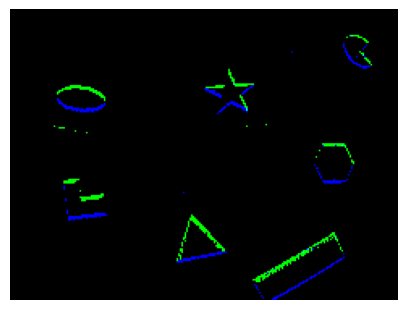

# 3. Formatting the Data

## 3.1 The Issue
The DAVIS dataset contains a LOT of data. Using each raw recording as a single data point would get highly complex and computationally expensive quite fast, both in terms of the high amount of data in the input, and also the requirement for the model to produce a complex output. For example, consider the target/label of the "shapes_translation" recording. We might expect a single number, or a vector of numbers. Let's try printing it out.

In [ ]:
print(dataset[0][1])

As we can see, we get a whole dictionary containing the positions and orientations of the camera across thousands of timestamps. Trying to get the model to output all this information from a recording would take a lot of computational resources and time.

## 3.2 Proposed Solution

Instead, let's train our model on something more understandable. To do this, we rearrange the dataset in a custom format that preserves the relevant information, and allows us to have inputs and desired outputs of a much smaller dimension. In this case, the proposed setup is as follows:

From each recording, create several datapoints of the form (frames, direction).

*   frames = set of n consecutive frames taken from the recording
*   direction = whether the camera was moving left or right while recording those n frames. Note: other directions are excluded becuase they are not mutually exclusive from left-right

In other words, we have simplified this to a binary classification task.

The input frames come from the event recordings. Where does the actual value for the direction come from (to compare to the model's output and perform gradient descent)? This will come from the dictionary we printed out earlier. We can find the x position of the camera at the timestamp of the first frame and compare that to the x position of the camera at the timestamp of the last frame.

## 3.3 Implementation of Solution
This first function below is optional, if you would like to compress your frames to save memory.

In [ ]:
# This function will only get called if the downsample flag is set to true
def downsample(frames, factor):
    num_frames, channels, height, width = frames.shape

    # Calculate new dimensions
    new_height = height // factor
    new_width = width // factor

    # Initialize the downsampled array
    downsampled_frames = numpy.zeros((num_frames, channels, new_height, new_width))

    for frame_idx in range(num_frames): # for each frame / channel, divide the array into blocks and sum the values in each block, creating a new array reducing each block into a single value corresponding to the sum
        for channel in range(channels):
            for i in range(new_height):
                for j in range(new_width):
                    block = frames[frame_idx, channel, i*factor:(i+1)*factor, j*factor:(j+1)*factor]
                    block_sum = numpy.sum(block)
                    downsampled_frames[frame_idx, channel, i, j] = block_sum

    return downsampled_frames.astype(numpy.int16)

The code below iterates through each recording, creates frames, and computes the target values for each set of n frames.

In [ ]:
downsample = False # Modify if you would like to compress the frames to have a smaller dimension
downsample_factor = 7 # How much to compress each dimension by
frames = list()
velocities = list()

for i in range(len(dataset)): # Iterate through each recording
    groundtruth = dataset[i][1]

    mean_diff = numpy.diff(list(zip(groundtruth["ts"], groundtruth["ts"][1:]))).mean() # Calculates the average time between each measurement of the groundtruth
    time_window = 10 * mean_diff # Modify this based on how much time you want each frame to bin events into
    intervalLength = 25 # Modify this based on how many frames you want in each data point

    transform = tonic.transforms.ToFrame(
        sensor_size = dataset.sensor_size,
        time_window = time_window,
    )

    if downsample:
        frames.append(downsample(transform(dataset[i][0][0]), downsample_factor))
    else:
        frames.append(transform(dataset[i][0][0]))

    velocities.append(list())

    offset = time_window * intervalLength / mean_diff # How many measurements apart of the motion capture system are the first and last frame
    start = 0
    increment = time_window / mean_diff


    while int(offset + start * increment) < len(groundtruth["point"]):
        dx = groundtruth["point"][int(offset + start * increment)][0] - groundtruth["point"][int(start * increment)][0] # How much the camera moved across the batch of n frames
        velocities[i].append(0 if dx > 0 else 1) # If the change in x was positive, the camera moved right, otherwise it moved left
        start += 1

## 3.4 Custom Dataset
The drawback of the ToFrame() function used above is that it puts all the frames in one list. We do not yet have sets of n consecutive frames. We only have their directions. We need to create several datapoints taking n consecutive frames from this list. One approach we could take is to create a new list that contains all these intervals. The problem with this is that copying this array takes a lot of memory, and we are limited on RAM usage. Instead, we create a CustomDataset class. This formats and creates the data point only when it is needed, significantly saving memory.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, frames, velocities, interval_length):
        self.frames = frames
        self.velocities = velocities
        self.interval_length = interval_length

    def __len__(self):
        length = 0
        for i in range(len(velocities)):
            length += len(self.velocities[i])
        return length

    def __getitem__(self, idx): # Loads and formats each datapoint when necessary
        recording_num = 0
        while idx >= len(self.velocities[recording_num]):
            idx -= len(self.velocities[recording_num])
            recording_num += 1
        start_idx = idx
        end_idx = start_idx + self.interval_length
        frame_batch = self.frames[recording_num][start_idx:end_idx] # creates an interval of n frames
        velocity = self.velocities[recording_num][idx] # pairs the frames with the corresponding displacement across those frames
        return frame_batch, velocity

# Assuming 'frames' and 'velocities' are your data and targets respectively
dataset = CustomDataset(frames, velocities, interval_length=intervalLength)

## 3.5 Dataloaders
Below, we randomly split the dataset into datapoints that will be used to train the model, and datapoints that will be used to test its accuracy.

In [ ]:
# DataLoader parameters
batch_size = 32
shuffle = True

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # splits the dataset into data used to train the model and data used to test its accuracy

# Create DataLoader
trainloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=shuffle)
testloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=shuffle)

# 4. Training the Model
The following code initializes the model and the functions that will be used to train it. This structure is adapted from the snnTorch Tutorials. Some things to note: The linear layer of the network has a high input count, due to the large dimensions of the DAVIS Camera frame. This value will have to be modified if you choose to compress the frames. The 2 outputs are for left and right.

## 4.1 Model Structure

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.95

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(76608, 2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)

  for step in range(data.size(0)):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.7, incorrect_rate=0.3)

## 4.2 Model Train
Buckle up, this is going to take a long time. Took about 30 minutes for me.

In [ ]:
num_epochs = 25

loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

Graph the results of the training by running the code below.

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

Hopefully, your graph is increasing over time and looks something like this. It may be better or worse than this depending on how the batches are randomly chosen. If it doesn't look like the accuracy got much better over the iterations, you can try re-randomizing the batches by re-running the code cell with the batch size and DataLoaders.

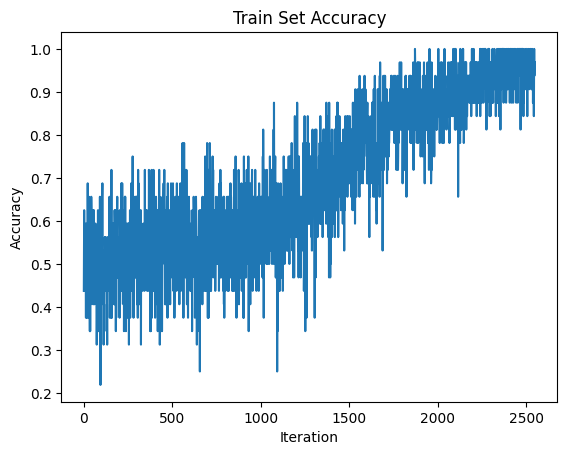

## 4.3 Model Test
Next let's try inputting some points that we didn't use for training into the neural network.

In [ ]:
net.eval()

batch_accuracy = []

with torch.no_grad():
    for data, targets in testloader:

        data = data.to(device)
        targets = targets.to(device)

        spk_rec = forward_pass(net, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        batch_accuracy.append(acc)

        print(f"Accuracy: {acc * 100:.2f}%\n")

print("The average accuracy across the testloader is:", 100 * statistics.mean(batch_accuracy), "%")

Graph the results of the testing by running the code below.

In [ ]:
fig = plt.figure(facecolor="w")
plt.plot(batch_accuracy)
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()
print("The average accuracy across the testloader is:", 100 * statistics.mean(batch_accuracy), "%")

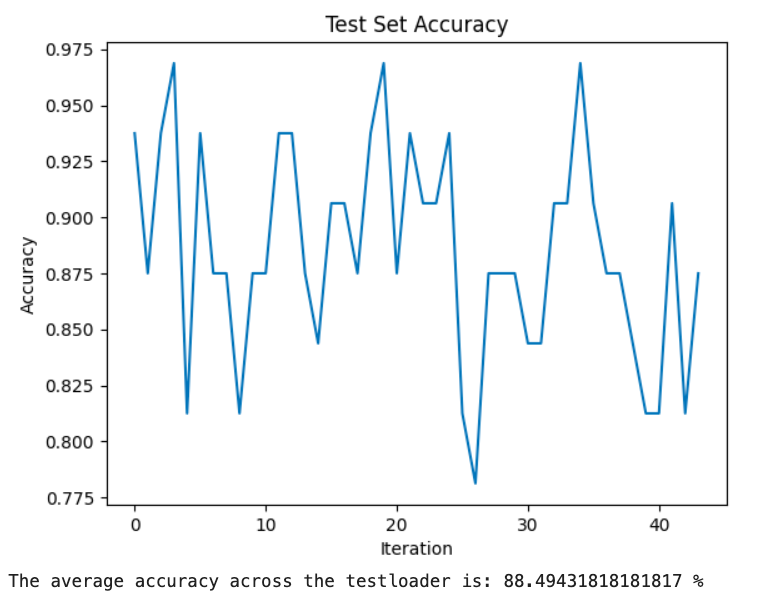

# 5. Results
That wraps up the tutorial! This was an example of how to use the DAVIS dataset to perform a binary classification task. Some final remarks...

## 5.1 Improving on This Setup



1.   Currently, each set of frames is mapped to a single value of left or right. However, it is completely possible that there is an even split of left and right movement across some sets of frames. It's also possible that the camera moved up and down and barely moved left or right at all in certain intervals. One possible solution is to remove these datapoints.
2.   For the purposes of this tutorial, the model is trained on 4 recordings. It is unclear if the accuracy of the model can be generalized to other recordings, or if the model has overfitted parameters to these specific recordings.
3.   There was overlap over the datapoints, as the set of all possible intervals of n recordings consist of overlapping intervals.




## 5.2 Implications

Hooray! We successfully trained a Spiking Neural Network to output direction using event camera data! This type of task has applications in Simultaneous Localization and Mapping (SLAM) algorithms, which track an agent's position and motion within an evironment. With traditional image data being large and computationally expensive, using event cameras and spiking neural networks could be more energy efficient on the large scale.